In [1]:
# here we link our notebook to our gdrive space
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
# our imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import load_model
import tensorflow as tf
from imutils import paths, rotate
import numpy as np
import argparse
import random
import cv2
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("Agg")
import os
import random as rn
# https://deeplizard.com/learn/video/HcW0DeWRggs

%matplotlib inline

In [ ]:
'''train_dir = '/content/drive/MyDrive/Zindi/makerere-fall-armyworm-crop-challenge/data/processed_dataV2/train_aug'
train_dir_negative = os.path.join(train_dir,'0')
train_dir_positive = os.path.join(train_dir,'1')
test_dir = '/content/drive/MyDrive/Zindi/makerere-fall-armyworm-crop-challenge/data/processed_dataV2/val'
test_dir_negative = os.path.join(test_dir,'0')
test_dir_positive = os.path.join(test_dir,'1')

train_generator = ImageDataGenerator(rescale=1./255)
train_generator = train_generator.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')
validation_generator = ImageDataGenerator(rescale=1./255)
validation_generator = validation_generator.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')'''

Found 28854 images belonging to 2 classes.
Found 245 images belonging to 2 classes.


In [2]:
def set_seed():
  os.environ['PYTHONHASHSEED'] = '0'
  os.environ['CUDA_VISIBLE_DEVICES'] = ''
  np.random.seed(1234)
  rn.seed(1234)
  tf.random.set_seed(1234)

# load dataset
def load_data(img_size, batch_size, label_mode):
  #train_dir = '/content/drive/MyDrive/Zindi/makerere-fall-armyworm-crop-challenge/data/processed_dataV2/train'
  train_dir = '/content/drive/MyDrive/Zindi/makerere-fall-armyworm-crop-challenge/data/processed_dataV2/train_aug_2k'
  train_dir_negative = os.path.join(train_dir,'0')
  train_dir_positive = os.path.join(train_dir,'1')
  val_dir = '/content/drive/MyDrive/Zindi/makerere-fall-armyworm-crop-challenge/data/processed_dataV2/val'
  val_dir_negative = os.path.join(val_dir,'0')
  val_dir_positive = os.path.join(val_dir,'1')

  train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, batch_size=batch_size, image_size=(img_size, img_size), label_mode=label_mode)
  train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  val_ds = tf.keras.preprocessing.image_dataset_from_directory(val_dir, batch_size=batch_size, image_size=(img_size, img_size), label_mode=label_mode)
  val_ds = val_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return train_ds, val_ds

def build_model(base_model, base_model_app, rescale_function, nb_predictions, img_size):
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2),
      ])
    preprocess_input = base_model_app.preprocess_input
    rescale = rescale_function
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    inputs = tf.keras.Input(shape=(img_size, img_size, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    prediction_layer = tf.keras.layers.Dense(nb_predictions, activation="sigmoid")
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)

    return model


def train_base_model(base_model, base_model_app, rescale_function, epochs, lr, model_path, img_size, batch_size, label_mode, nb_predictions):
    base_model.trainable = False
    
    model = build_model(base_model, base_model_app, rescale_function, nb_predictions, img_size)

    model.summary()

    opt = Adam(learning_rate=lr, decay=lr / epochs)
    model.compile(loss="binary_crossentropy", optimizer=opt,
					metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
    
    # load dataset
    train_ds, val_ds = load_data(img_size, batch_size, label_mode)

    history = model.fit(
    train_ds,
    epochs = epochs,
    validation_data = val_ds)

    model.save(model_path+'h5', save_format="h5")

    return history

def get_metrics(history):
  history = history.history
  acc = history['accuracy']
  val_acc = history['val_accuracy']
  loss = history['loss']
  val_loss = history['val_loss']
  return acc, val_acc, loss, val_loss

def plot_train_eval(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

Found 1374 files belonging to 2 classes.
Found 245 files belonging to 2 classes.
Epoch 1/50
11/11 [==============================] - 53s 4s/step - loss: 0.7254 - accuracy: 0.5808 - precision_8: 0.5458 - recall_8: 0.5902 - val_loss: 0.7384 - val_accuracy: 0.5184 - val_precision_8: 0.5252 - val_recall_8: 0.5959
Epoch 2/50
11/11 [==============================] - 45s 4s/step - loss: 0.6895 - accuracy: 0.6157 - precision_8: 0.5939 - recall_8: 0.5801 - val_loss: 0.6928 - val_accuracy: 0.5673 - val_precision_8: 0.5579 - val_recall_8: 0.6490
Epoch 3/50
11/11 [==============================] - 46s 4s/step - loss: 0.6354 - accuracy: 0.6885 - precision_8: 0.6366 - recall_8: 0.6325 - val_loss: 0.6528 - val_accuracy: 0.6327 - val_precision_8: 0.6022 - val_recall_8: 0.6857
Epoch 4/50
11/11 [==============================] - 44s 4s/step - loss: 0.6154 - accuracy: 0.7031 - precision_8: 0.6501 - recall_8: 0.6492 - val_loss: 0.6191 - val_accuracy: 0.6776 - val_precision_8: 0.6272 - val_recall_8: 0.7143

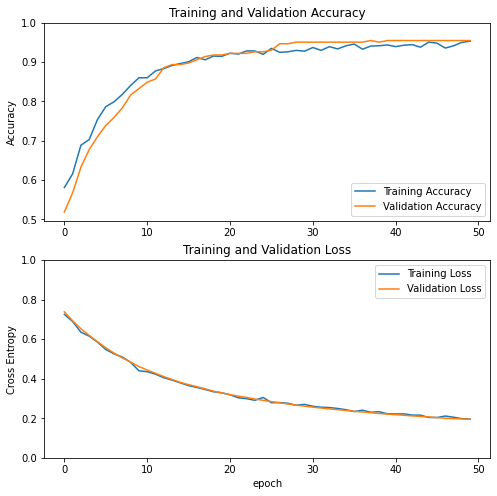

In [ ]:
# EXP 1 : training MobileNetV2 with 2 neurons at predictions
'''
config
-----------
'''
img_size = 224
batch_size = 128
IMG_SHAPE = (img_size, img_size, 3)
dir = '/content/drive/MyDrive/Zindi/makerere-fall-armyworm-crop-challenge/saved/V2/'

base_model_mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
base_model_mobilenetv2_app = tf.keras.applications.mobilenet_v2
rescale_function = tf.keras.layers.Rescaling(1./127.5, offset=-1)
epochs = 50
lr = 0.0001
model_path = dir + 'mobilenetv250_'
set_seed()
history = train_base_model(base_model_mobilenetv2, base_model_mobilenetv2_app, rescale_function, epochs, lr, model_path, img_size, batch_size, 'categorical', 2)
plot_train_eval(history)

In [ ]:
# Exp 1 suite - fine tune the precedent mobilenetV2 model
set_seed()
'''base_model_mobilenetv2.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_mobilenetv2.layers[:fine_tune_at]:
  layer.trainable = False
  '''
model = load_model('/content/drive/MyDrive/Zindi/makerere-fall-armyworm-crop-challenge/saved/V2/mobilenetv250_h5')
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])
fine_tune_epochs = 20
initial_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

# load dataset
train_ds, val_ds = load_data(img_size=224, batch_size=128, label_mode='categorical')

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=50,
                         validation_data=val_ds)
model_path = '/content/drive/MyDrive/Zindi/makerere-fall-armyworm-crop-challenge/saved/V2/mobilenetv250_ft20h5'
model.save(model_path+'h5', save_format="h5")

Found 1374 files belonging to 2 classes.
Found 245 files belonging to 2 classes.
Epoch 51/70


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


11/11 [==============================] - 197s 8s/step - loss: 0.1937 - accuracy: 0.9469 - val_loss: 0.1649 - val_accuracy: 0.9592
Epoch 52/70
11/11 [==============================] - 45s 4s/step - loss: 0.1659 - accuracy: 0.9512 - val_loss: 0.1494 - val_accuracy: 0.9673
Epoch 53/70
11/11 [==============================] - 44s 4s/step - loss: 0.1439 - accuracy: 0.9541 - val_loss: 0.1518 - val_accuracy: 0.9633
Epoch 54/70
11/11 [==============================] - 44s 4s/step - loss: 0.1451 - accuracy: 0.9556 - val_loss: 0.1232 - val_accuracy: 0.9673
Epoch 55/70
11/11 [==============================] - 43s 4s/step - loss: 0.1245 - accuracy: 0.9658 - val_loss: 0.1211 - val_accuracy: 0.9714
Epoch 56/70
11/11 [==============================] - 43s 4s/step - loss: 0.1204 - accuracy: 0.9636 - val_loss: 0.1155 - val_accuracy: 0.9714
Epoch 57/70
11/11 [==============================] - 45s 4s/step - loss: 0.1285 - accuracy: 0.9578 - val_loss: 0.1147 - val_accuracy: 0.9714
Epoch 58/70
11/11 [=====

Found 1374 files belonging to 2 classes.
Found 245 files belonging to 2 classes.
Epoch 1/50
11/11 [==============================] - 47s 4s/step - loss: 0.8186 - accuracy: 0.4680 - precision_10: 0.4677 - recall_10: 0.4643 - auc_1: 0.4628 - val_loss: 0.7424 - val_accuracy: 0.4980 - val_precision_10: 0.4958 - val_recall_10: 0.4836 - val_auc_1: 0.5283
Epoch 2/50
11/11 [==============================] - 43s 4s/step - loss: 0.7527 - accuracy: 0.5262 - precision_10: 0.5253 - recall_10: 0.5444 - auc_1: 0.5409 - val_loss: 0.7036 - val_accuracy: 0.5429 - val_precision_10: 0.5439 - val_recall_10: 0.5082 - val_auc_1: 0.5807
Epoch 3/50
11/11 [==============================] - 43s 4s/step - loss: 0.6801 - accuracy: 0.6033 - precision_10: 0.6006 - recall_10: 0.6172 - auc_1: 0.6390 - val_loss: 0.6680 - val_accuracy: 0.5878 - val_precision_10: 0.5946 - val_recall_10: 0.5410 - val_auc_1: 0.6395
Epoch 4/50
11/11 [==============================] - 45s 4s/step - loss: 0.6804 - accuracy: 0.6026 - precision

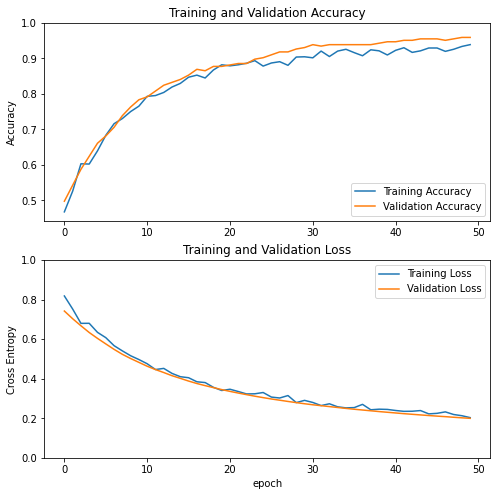

In [ ]:
# EXP 2 : training MobileNetV2 with 1 prediction neuron
'''
config
-----------
'''
img_size = 224
batch_size = 128
IMG_SHAPE = (img_size, img_size, 3)
dir = '/content/drive/MyDrive/Zindi/makerere-fall-armyworm-crop-challenge/saved/V2/'

base_model_mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
base_model_mobilenetv2_app = tf.keras.applications.mobilenet_v2
rescale_function = tf.keras.layers.Rescaling(1./127.5, offset=-1)
epochs = 50
lr = 0.0001
model_path = dir + 'mobilenetv250__'
set_seed()
history = train_base_model(base_model_mobilenetv2, base_model_mobilenetv2_app, rescale_function, epochs, lr, model_path, img_size, batch_size, 'binary', 1)
plot_train_eval(history)

In [ ]:
# Exp 2 suite - fine tune the precedent mobilenetV2 model

base_model_mobilenetv2.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_mobilenetv2.layers[:fine_tune_at]:
  layer.trainable = False
model = load_model('/content/drive/MyDrive/Zindi/makerere-fall-armyworm-crop-challenge/saved/V2/mobilenetv250__h5')
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])
fine_tune_epochs = 20
initial_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

# load dataset
train_ds, val_ds = load_data(img_size, batch_size, label_mode='binary')

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)
model_path = '/content/drive/MyDrive/Zindi/makerere-fall-armyworm-crop-challenge/saved/V2/mobilenetv250__ft20h5'
model.save(model_path+'h5', save_format="h5")

Found 1374 files belonging to 2 classes.
Found 245 files belonging to 2 classes.
Epoch 50/70


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


11/11 [==============================] - 47s 4s/step - loss: 0.2038 - accuracy: 0.9345 - val_loss: 0.1647 - val_accuracy: 0.9592
Epoch 51/70
11/11 [==============================] - 44s 4s/step - loss: 0.1721 - accuracy: 0.9403 - val_loss: 0.1445 - val_accuracy: 0.9714
Epoch 52/70
11/11 [==============================] - 45s 4s/step - loss: 0.1474 - accuracy: 0.9541 - val_loss: 0.1332 - val_accuracy: 0.9755
Epoch 53/70
11/11 [==============================] - 45s 4s/step - loss: 0.1308 - accuracy: 0.9563 - val_loss: 0.1182 - val_accuracy: 0.9755
Epoch 55/70
11/11 [==============================] - 45s 4s/step - loss: 0.1146 - accuracy: 0.9658 - val_loss: 0.1029 - val_accuracy: 0.9796
Epoch 57/70
11/11 [==============================] - 44s 4s/step - loss: 0.1146 - accuracy: 0.9636 - val_loss: 0.0973 - val_accuracy: 0.9755
Epoch 58/70
11/11 [==============================] - 45s 4s/step - loss: 0.1103 - accuracy: 0.9709 - val_loss: 0.0989 - val_accuracy: 0.9755
Epoch 59/70
11/11 [======

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_4 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

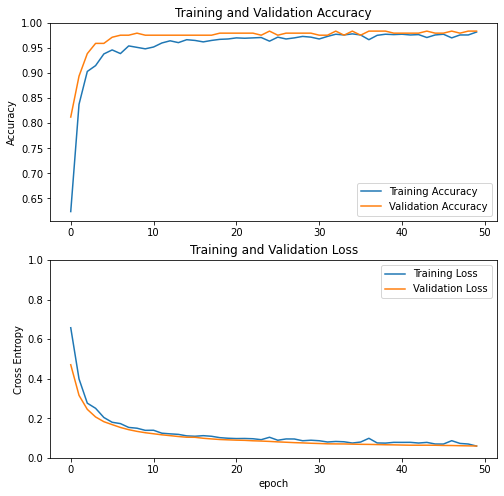

In [50]:
# EXP 2 : training MobileNetV2 with 1 prediction neuron
'''
config
-----------
'''
img_size = 224
batch_size = 128
IMG_SHAPE = (img_size, img_size, 3)
dir = '/content/drive/MyDrive/Zindi/makerere-fall-armyworm-crop-challenge/saved/V2/'

base_model_mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
base_model_mobilenetv2_app = tf.keras.applications.mobilenet_v2
rescale_function = tf.keras.layers.Rescaling(1./127.5, offset=-1)
epochs = 50
lr = 0.001
model_path = dir + 'mobilenetv250___'
set_seed()
data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2),
      ])
preprocess_input = base_model_mobilenetv2_app.preprocess_input
rescale = rescale_function
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
base_model_mobilenetv2.trainable = False
inputs = tf.keras.Input(shape=(img_size, img_size, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model_mobilenetv2(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
prediction_layer = tf.keras.layers.Dense(1, activation="sigmoid")
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
  
model.summary()
mcp_save_best = ModelCheckpoint(model_path+'_best.h5', save_best_only=True, monitor='val_loss', mode='min')
opt = Adam(learning_rate=lr, decay=lr / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt,
					metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
    
# load dataset
train_ds, val_ds = load_data(img_size, batch_size, 'binary')

history = model.fit(
    train_ds,
    epochs = epochs,
    validation_data = val_ds,
    callbacks=[mcp_save_best])

model.save(model_path+'h5', save_format="h5")
#history = train_base_model(base_model_mobilenetv2, base_model_mobilenetv2_app, rescale_function, epochs, lr, model_path, img_size, batch_size, 'binary', 1)
plot_train_eval(history)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

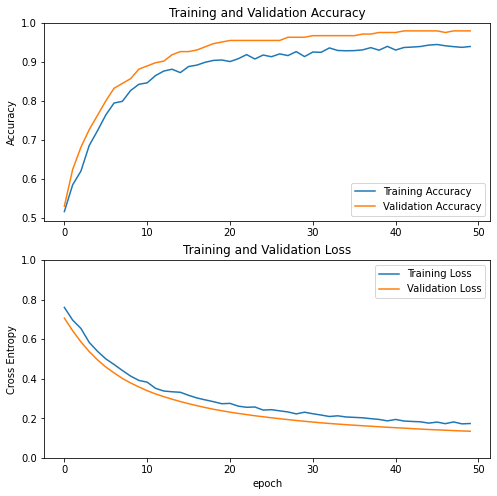

In [4]:
# EXP 2 : training MobileNetV2 with 1 prediction neuron
'''
config
-----------
'''
img_size = 224
batch_size = 128
IMG_SHAPE = (img_size, img_size, 3)
dir = '/content/drive/MyDrive/Zindi/makerere-fall-armyworm-crop-challenge/saved/V2/'

base_model_mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
base_model_mobilenetv2_app = tf.keras.applications.mobilenet_v2
rescale_function = tf.keras.layers.Rescaling(1./127.5, offset=-1)
epochs = 50
lr = 0.0001
model_path = dir + 'mobilenetv250_v4'
set_seed()
data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2),
      ])
preprocess_input = base_model_mobilenetv2_app.preprocess_input
rescale = rescale_function
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
base_model_mobilenetv2.trainable = False
inputs = tf.keras.Input(shape=(img_size, img_size, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model_mobilenetv2(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
prediction_layer = tf.keras.layers.Dense(1, activation="sigmoid")
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
  
model.summary()
mcp_save_best = ModelCheckpoint(model_path+'_best.h5', save_best_only=True, monitor='val_loss', mode='min')
opt = Adam(learning_rate=lr, decay=lr / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt,
					metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
    
# load dataset
train_ds, val_ds = load_data(img_size, batch_size, 'binary')

history = model.fit(
    train_ds,
    epochs = epochs,
    validation_data = val_ds,
    callbacks=[mcp_save_best])

model.save(model_path+'h5', save_format="h5")
#history = train_base_model(base_model_mobilenetv2, base_model_mobilenetv2_app, rescale_function, epochs, lr, model_path, img_size, batch_size, 'binary', 1)
plot_train_eval(history)

In [18]:
'''
# Exp 2 suite - fine tune the precedent mobilenetV2 model
set_seed()

#base_model_mobilenetv2.trainable = False

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_mobilenetv2.layers[:fine_tune_at]:
  layer.trainable = False

model_path = '/content/drive/MyDrive/Zindi/makerere-fall-armyworm-crop-challenge/saved/V2/mobilenetv250___ft20h5'
mcp_save_best = ModelCheckpoint(model_path+'_best.h5', save_best_only=True, monitor='val_loss', mode='min')
tensorboard_cb = TensorBoard(log_dir='logs')

model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01),
              metrics=["accuracy", tf.keras.metrics.AUC()])
fine_tune_epochs = 30
initial_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs
img_size = 224
batch_size = 128

# load dataset
#train_ds, val_ds = load_data(img_size, batch_size, label_mode='binary')

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         callbacks=[mcp_save_best])
model.save(model_path+'h5', save_format="h5")
'''

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


11/11 [==============================] - 10s 392ms/step - loss: 0.4134 - accuracy: 0.9003 - auc_5: 0.9445 - val_loss: 0.0993 - val_accuracy: 0.9633 - val_auc_5: 0.9932
Epoch 51/80
11/11 [==============================] - 6s 306ms/step - loss: 0.0842 - accuracy: 0.9687 - auc_5: 0.9949 - val_loss: 0.0662 - val_accuracy: 0.9673 - val_auc_5: 0.9963
Epoch 52/80
11/11 [==============================] - 6s 258ms/step - loss: 0.2967 - accuracy: 0.9032 - auc_5: 0.9644 - val_loss: 0.0691 - val_accuracy: 0.9673 - val_auc_5: 0.9962
Epoch 53/80
11/11 [==============================] - 6s 253ms/step - loss: 0.0627 - accuracy: 0.9789 - auc_5: 0.9977 - val_loss: 0.0675 - val_accuracy: 0.9714 - val_auc_5: 0.9966
Epoch 54/80
11/11 [==============================] - 6s 261ms/step - loss: 0.1565 - accuracy: 0.9381 - auc_5: 0.9866 - val_loss: 0.0670 - val_accuracy: 0.9755 - val_auc_5: 0.9968
Epoch 55/80
11/11 [==============================] - 6s 255ms/step - loss: 0.0770 - accuracy: 0.9694 - auc_5: 0.9963

In [51]:
model = load_model('/content/drive/MyDrive/Zindi/makerere-fall-armyworm-crop-challenge/saved/V2/mobilenetv250___h5')
#train_ds, val_ds = load_data(img_size=224, batch_size=128)
model.evaluate(val_ds)

2/2 [==============================] - 2s 164ms/step - loss: 0.0596 - accuracy: 0.9837 - precision_4: 0.9836 - recall_4: 0.9836 - auc_7: 0.9980


[0.05963903293013573,
 0.9836734533309937,
 0.9836065769195557,
 0.9836065769195557,
 0.9979674816131592]

In [30]:
model = load_model('/content/drive/MyDrive/Zindi/makerere-fall-armyworm-crop-challenge/saved/V2/mobilenetv250__ft20h5h5')

source = '/content/drive/MyDrive/Zindi/makerere-fall-armyworm-crop-challenge/data/processed_dataV2/test/ #val/1/id_v38vrc5nn7we5.jpg'
img = cv2.imread(source)
image_g = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image_g = img_to_array(image_g)
    
pred = model.predict(np.expand_dims(image_g, axis=0))

print (pred)


[[0.97774327]]


In [14]:
import csv

def make_submission(weights_path, sub_fn):
  baseline = '/content/drive/MyDrive/Zindi/makerere-fall-armyworm-crop-challenge/data/'
  model = load_model(weights_path)
  source = baseline+'processed_dataV2/test/'

  # open submissions file
  header = ['Image_id', 'Label']
  with open(baseline+sub_fn, 'a', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    # write the header
    writer.writerow(header)

    for fn in os.listdir(source):
      img = cv2.imread(source+fn)
      image_g = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      image_g = img_to_array(image_g)
      
      pred = model.predict(np.expand_dims(image_g, axis=0))

      infos = [fn, pred[0][0]]
      writer.writerow(infos)

# write submission file for model mobilenetv2ft20
'''weights_path = '/content/drive/MyDrive/Zindi/makerere-fall-armyworm-crop-challenge/saved/V2/mobilenetv250__ft20h5h5'
sub_fn = 'sub_mbnft20.csv'
make_submission(weights_path, sub_fn)'''

"weights_path = '/content/drive/MyDrive/Zindi/makerere-fall-armyworm-crop-challenge/saved/V2/mobilenetv250__ft20h5h5'\nsub_fn = 'sub_mbnft20.csv'\nmake_submission(weights_path, sub_fn)"

In [52]:
# write submission file for model mobilenetv2___50
weights_path = '/content/drive/MyDrive/Zindi/makerere-fall-armyworm-crop-challenge/saved/V2/mobilenetv250___h5'
sub_fn = 'sub_mbn50___h5.csv'
make_submission(weights_path, sub_fn)